# QuakeFlow demo

In [1]:
import os
root_path = "./QuakeFlow/slurm/"
def run(root_path, script):
    cmd = f"cd {root_path} && python {script}"
    print(cmd)
    os.system(cmd)

### Set configuration parameters

**Edit the [config.json](./QuakeFlow/slurm/config.json) file to add parameters of studying region**

**Edit the [set_config.py](./QuakeFlow/slurm/set_config.py) file to select the studying region**

You can search for earthquake information here: [USGS](https://earthquake.usgs.gov/earthquakes/map/?extent=10.66061,-133.33008&extent=58.53959,-56.68945&range=month&magnitude=all&settings=true)

You can search for seismic network information here: [IRIS](http://ds.iris.edu/gmap/#network=*&starttime=2023-10-01&planet=earth)

In [2]:
run(root_path, "set_config.py")

cd ./QuakeFlow/slurm/ && python set_config.py
{
    "num_nodes": 1,
    "sampling_rate": 100,
    "degree2km": 111.1949,
    "channel": "HH*,BH*,EH*,HN*",
    "level": "response",
    "gamma": {
        "zmin_km": 0,
        "zmax_km": 60
    },
    "cctorch": {
        "sampling_rate": 100,
        "time_before": 0.25,
        "time_after": 1.0,
        "components": "ENZ123",
        "component_mapping": {
            "3": 0,
            "2": 1,
            "1": 2,
            "E": 0,
            "N": 1,
            "Z": 2
        }
    },
    "longitude0": -117.504,
    "latitude0": 35.705,
    "maxradius_degree": 0.5,
    "minlatitude": 35.205,
    "maxlatitude": 36.205,
    "minlongitude": -118.004,
    "maxlongitude": -117.004,
    "starttime": "2019-07-04T17:00:00",
    "endtime": "2019-07-04T19:00:00",
    "provider": [
        "SCEDC",
        "IRIS"
    ],
    "network": "CI"
}


### Download stations and events

**Edit the [download_station.py](./QuakeFlow/slurm/download_station.py) file to select the studying region**

**Edit the [download_catalog.py](./QuakeFlow/slurm/download_catalog.py) file to select the studying region**

In [3]:
run(root_path, "download_station.py")

run(root_path, "download_catalog.py")

cd ./QuakeFlow/slurm/ && python download_station.py
{
    "num_nodes": 1,
    "sampling_rate": 100,
    "degree2km": 111.1949,
    "channel": "HH*,BH*,EH*,HN*",
    "level": "response",
    "gamma": {
        "zmin_km": 0,
        "zmax_km": 60
    },
    "cctorch": {
        "sampling_rate": 100,
        "time_before": 0.25,
        "time_after": 1.0,
        "components": "ENZ123",
        "component_mapping": {
            "3": 0,
            "2": 1,
            "1": 2,
            "E": 0,
            "N": 1,
            "Z": 2
        }
    },
    "longitude0": -117.504,
    "latitude0": 35.705,
    "maxradius_degree": 0.5,
    "minlatitude": 35.205,
    "maxlatitude": 36.205,
    "minlongitude": -118.004,
    "maxlongitude": -117.004,
    "starttime": "2019-07-04T17:00:00",
    "endtime": "2019-07-04T19:00:00",
    "provider": [
        "SCEDC",
        "IRIS"
    ],
    "network": "CI"
}
Parse 150 channels of SCEDC into csv
Parse 52 stations of SCEDC into json
Parse 150 channels 

### Download continuous waveform data

**Edit the [download_waveform_v2.py](./QuakeFlow/slurm/download_waveform_v2.py) file to select the studying region**

In [4]:
run(root_path, "download_waveform_v2.py")

cd ./QuakeFlow/slurm/ && python download_waveform_v2.py
No data available for request from http://service.scedc.caltech.edu: 2019-07-04T17:00:00 - 2019-07-04T18:00:00
No data available for request from http://service.scedc.caltech.edu: 2019-07-04T18:00:00 - 2019-07-04T19:00:00
Already downloaded from http://service.iris.edu: 2019-07-04T17:00:00 - 2019-07-04T18:00:00
Already downloaded from http://service.iris.edu: 2019-07-04T18:00:00 - 2019-07-04T19:00:00


### Run Phase Picking: PhaseNet

**Edit the [run_phasenet.py](./QuakeFlow/slurm/run_phasenet.py) file to select the studying region**

In [5]:
run(root_path, "run_phasenet.py")

cd ./QuakeFlow/slurm/ && python run_phasenet.py


2023-10-02 07:07:35.955460: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 07:07:35.981601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-02 07:07:35.981639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-02 07:07:35.981658: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-02 07:07:35.986697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-02 07:07:35.986900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

Done with 8706 P-picks and 9200 S-picks


### Run Phase Association: GaMMA

**Edit the [run_gamma.py](./QuakeFlow/slurm/run_gamma.py) file to select the studying region**

In [6]:
run(root_path, "run_gamma.py")

cd ./QuakeFlow/slurm/ && python run_gamma.py
num_nodes: 1
sampling_rate: 100
degree2km: 111.1949
channel: HH*,BH*,EH*,HN*
level: response
gamma: {'zmin_km': 0, 'zmax_km': 60}
cctorch: {'sampling_rate': 100, 'time_before': 0.25, 'time_after': 1.0, 'components': 'ENZ123', 'component_mapping': {'3': 0, '2': 1, '1': 2, 'E': 0, 'N': 1, 'Z': 2}}
longitude0: -117.504
latitude0: 35.705
maxradius_degree: 0.5
minlatitude: 35.205
maxlatitude: 36.205
minlongitude: -118.004
maxlongitude: -117.004
starttime: 2019-07-04T17:00:00
endtime: 2019-07-04T19:00:00
provider: ['SCEDC', 'IRIS']
network: CI
use_dbscan: True
use_amplitude: True
method: BGMM
oversample_factor: 8
vel: {'p': 6.0, 's': 3.4285714285714284}
dims: ['x(km)', 'y(km)', 'z(km)']
x(km): [-45.14694189  45.14694189]
y(km): [-55.59745  55.59745]
z(km): (0, 20)
bfgs_bounds: ((-46.14694188923431, 46.14694188923431), (-56.59745, 56.59745), (0, 21), (None, None))
dbscan_eps: 10
dbscan_min_samples: 3
min_picks_per_eq: 5
min_p_picks_per_eq: 0
min_s_

### Visualization

In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import obspy

**Read Catalog**

In [8]:
with open(f"{root_path}/local/demo/config.json") as f:
    config = json.load(f)
plot_standard_catalog = True

gamma_events = pd.read_csv(f"{root_path}/local/demo/gamma/gamma_events.csv", parse_dates=["time"])
gamma_events.sort_values("gamma_score", ascending=False, inplace=True)
gamma_picks = pd.read_csv(f"{root_path}/local/demo/gamma/gamma_picks.csv", parse_dates=["phase_time"])
gamma_picks["phase_time"] = gamma_picks["phase_time"].dt.tz_localize("UTC")
stations = pd.read_csv(f"{root_path}/local/demo/obspy/stations.csv")
stations["location"] = stations["location"].fillna("")
if plot_standard_catalog:
    standard_catalog = pd.read_csv(f"{root_path}/local/demo/obspy/catalog.csv", parse_dates=["time"])

**Select event and picks for visulization**

In [24]:
event = gamma_events.iloc[0]
picks = gamma_picks[gamma_picks.event_index == event.event_index]
stations["id"] = stations.network + "." + stations.station + "." + stations.location + "." + stations.instrument
stations["dist_km"] = np.sqrt((stations.latitude - event.latitude)**2 + (stations.longitude - event.longitude)**2 * np.cos(event.latitude)**2) * 111.19


**Load waveforms**

In [25]:
begin_time = event.time - pd.Timedelta(seconds=0)
end_time = event.time + pd.Timedelta(seconds=30)
waveforms = obspy.Stream()
try:
    waveforms += obspy.read(f"{root_path}/local/demo/waveforms/{begin_time.year}-{begin_time.dayofyear}/{begin_time.hour}/*.mseed")
except Exception as e:
    print(e)
if end_time.hour != begin_time.hour:
    try:
        waveforms += obspy.read(f"{root_path}/local/demo/waveforms/{end_time.year}-{end_time.dayofyear}/{end_time.hour}/*.mseed")
    except Exception as e:
        print(e)
stream = waveforms.copy()
stream.trim(obspy.UTCDateTime(begin_time), obspy.UTCDateTime(end_time), pad=True, fill_value=0);

**Plotting picks**

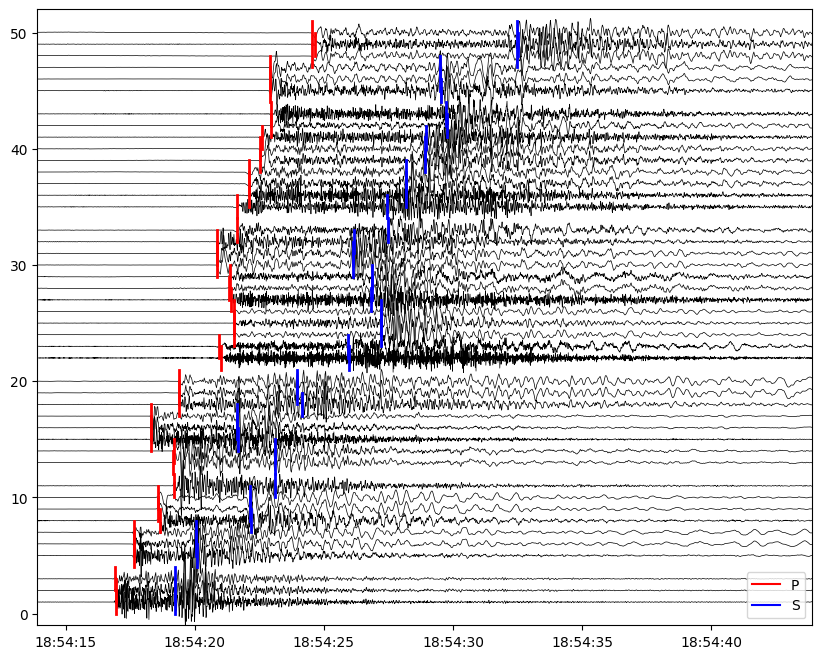

In [26]:
component = "Z"
stations = stations[stations["component"] == component]
stations.sort_values("dist_km", inplace=True)
stations.reset_index(inplace=True, drop=True)
normalize = lambda x: (x-np.mean(x))/(np.std(x) + np.finfo(float).eps)/4
fig, ax = plt.subplots(figsize=(10, 8))

for i, station in stations.iterrows():
    dist_km = station.dist_km
    tr = stream.select(id=station.id+component)
    if len(tr) == 1:
        tr = tr[0]
        # ax.plot(tr.times("matplotlib") , normalize(tr.data) + dist_km, "k", linewidth=0.5)
        ax.plot(tr.times("matplotlib") , normalize(tr.data) + i, "k", linewidth=0.5)

color = {"P": "r", "S": "b"}
for _, pick in picks.iterrows():
    y = stations[stations.id == pick.station_id].index.values[0]
    ax.plot([pick.phase_time, pick.phase_time], [y-1, y+1], color[pick.phase_type], linewidth=2)
ax.plot([], [], "r", label="P")
ax.plot([], [], "b", label="S")
ax.legend(loc="lower right")
ax.xaxis_date()
ax.set_xlim(begin_time, end_time)
ax.set_ylim(-1, len(stations))
plt.show()

**Plotting catalog**

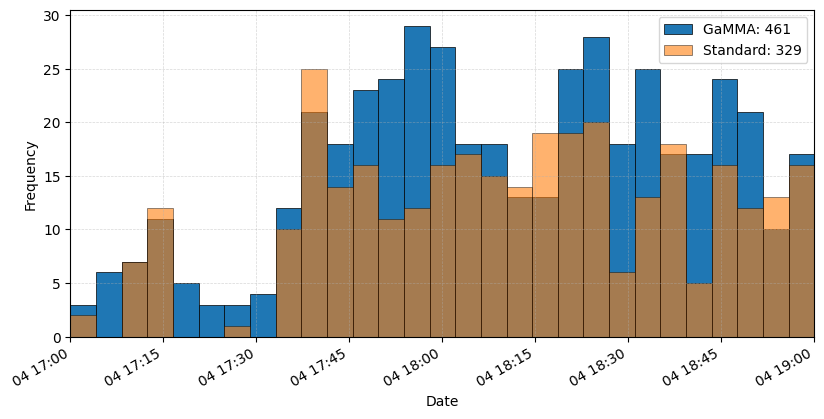

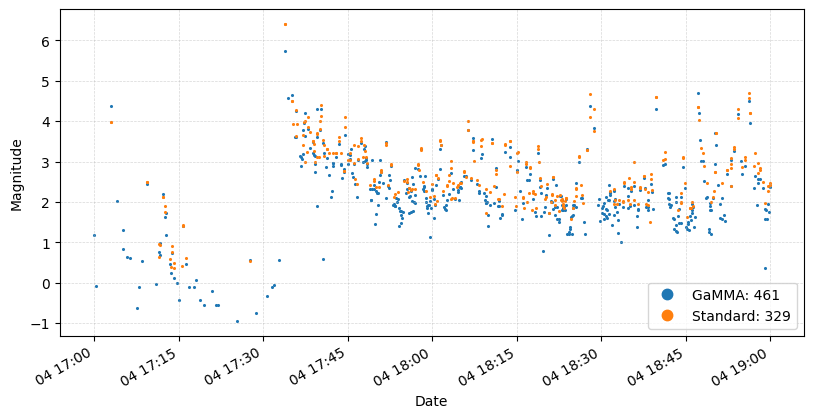

In [12]:
gamma_label = "GaMMA"
standard_label = "Standard"

bins = pd.date_range(start=config["starttime"], end=config["endtime"], periods=30)
plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([1.5, 1.0]))
plt.hist(
    gamma_events["time"],
    bins=bins,
    edgecolor="k",
    alpha=1.0,
    linewidth=0.5,
    label=f"{gamma_label}: {len(gamma_events['time'])}",
)
if plot_standard_catalog:
    plt.hist(
        standard_catalog["time"],
        bins=bins,
        edgecolor="k",
        alpha=0.6,
        linewidth=0.5,
        label=f"{standard_label}: {len(standard_catalog['time'])}",
    )
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis="x", tight=True)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d:%H'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

gamma_markersize = min(5, 1e5 / len(gamma_events))
standard_markersize = min(5, 1e4 / len(standard_catalog))
plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([1.5, 1.0]))

plt.scatter(
    gamma_events["time"], gamma_events["magnitude"], s=gamma_markersize, alpha=1.0, linewidth=0, rasterized=True
)
if plot_standard_catalog:
    plt.scatter(
        standard_catalog["time"],
        standard_catalog["magnitude"],
        s=standard_markersize,
        alpha=1.0,
        linewidth=0,
        rasterized=True,
    )

plt.ylabel("Magnitude")
plt.xlabel("Date")
plt.gcf().autofmt_xdate()

plt.gca().set_prop_cycle(None)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot(xlim[0] - 10, ylim[0] - 10, ".", markersize=15, alpha=1.0, label=f"{gamma_label}: {len(gamma_events)}")
plt.plot(xlim[0] - 10, ylim[0] - 10, ".", markersize=15, alpha=1.0, label=f"{standard_label}: {len(standard_catalog)}")
plt.legend(loc="lower right")
plt.xlim(xlim)
plt.ylim(ylim)
plt.grid(linestyle="--", linewidth=0.5, alpha=0.5)
plt.show()

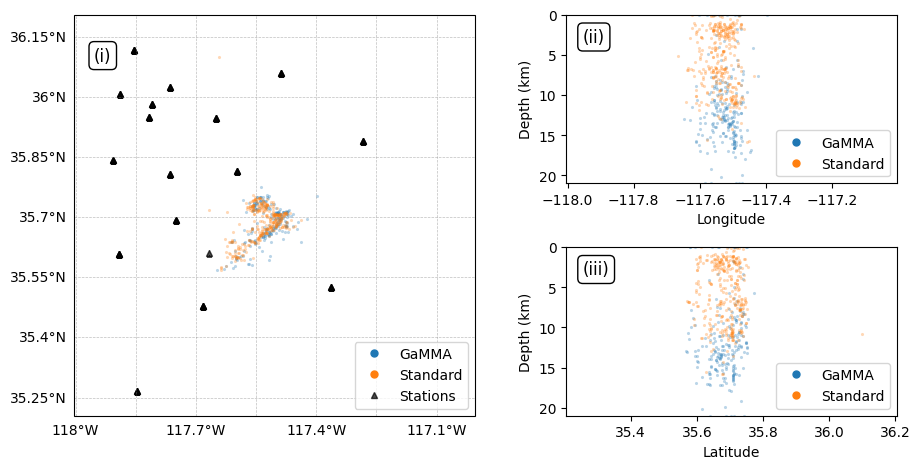

In [13]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

gamma_events = gamma_events[gamma_events["gamma_score"] > 30]

fig = plt.figure(figsize=plt.rcParams["figure.figsize"] * np.array([1.5, 1]))
box = dict(boxstyle="round", facecolor="white", alpha=1)
text_loc = [0.05, 0.92]

gamma_markersize = min(5, 1e5 / len(gamma_events["latitude"]))
standard_markersize = min(5, 1e4 / len(standard_catalog["latitude"]))
alpha = 0.3
grd = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(grd[:, 0], projection=ccrs.PlateCarree())
ax1.set_extent(
    [config["minlongitude"], config["maxlongitude"], config["minlatitude"], config["maxlatitude"]],
    crs=ccrs.PlateCarree(),
)


ax1.coastlines(resolution="10m", color="gray", linewidth=0.5)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
gl.top_labels = False
gl.right_labels = False
ax1.scatter(gamma_events["longitude"], gamma_events["latitude"], s=gamma_markersize, linewidth=0, alpha=alpha)
if plot_standard_catalog:
    ax1.scatter(
        standard_catalog["longitude"], standard_catalog["latitude"], s=standard_markersize, linewidth=0, alpha=alpha
    )
# ax1.axis("scaled")
# ax1.set_xlim([config["minlongitude"], config["maxlongitude"]])
# ax1.set_ylim([config["minlatitude"], config["maxlatitude"]])
# ax1.set_xlabel("Latitude")
# ax1.set_ylabel("Longitude")
ax1.set_prop_cycle(None)
ax1.plot(
    config["minlongitude"] - 10, config["minlatitude"] - 10, ".", markersize=10, label=f"{gamma_label}", rasterized=True
)
ax1.plot(
    config["minlongitude"] - 10,
    config["minlatitude"] - 10,
    ".",
    markersize=10,
    label=f"{standard_label}",
    rasterized=True,
)
ax1.plot(stations["longitude"], stations["latitude"], "k^", markersize=5, alpha=0.7, label="Stations")
ax1.text(
    text_loc[0],
    text_loc[1],
    "(i)",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.legend(loc="lower right")

ax2 = fig.add_subplot(grd[0, 1])
ax2.scatter(
    gamma_events["longitude"],
    gamma_events["depth_km"],
    s=gamma_markersize,
    linewidth=0,
    alpha=alpha,
    rasterized=True,
)
if plot_standard_catalog:
    ax2.scatter(
        standard_catalog["longitude"],
        standard_catalog["depth_km"],
        s=standard_markersize,
        linewidth=0,
        alpha=alpha,
        rasterized=True,
    )
ax2.set_xlim([config["minlongitude"], config["maxlongitude"]])
ax2.set_ylim([0, 21])
ax2.invert_yaxis()
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Depth (km)")
ax2.set_prop_cycle(None)
ax2.plot(config["minlongitude"] - 10, 31, ".", markersize=10, label=f"{gamma_label}")
ax2.plot(31, 31, ".", markersize=10, label=f"{standard_label}")
ax2.text(
    text_loc[0],
    text_loc[1],
    "(ii)",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.legend(loc="lower right")


fig.add_subplot(grd[1, 1])
plt.scatter(
    gamma_events["latitude"],
    gamma_events["depth_km"],
    s=gamma_markersize,
    linewidth=0,
    alpha=alpha,
    rasterized=True,
)
if plot_standard_catalog:
    plt.scatter(
        standard_catalog["latitude"],
        standard_catalog["depth_km"],
        s=standard_markersize,
        linewidth=0,
        alpha=alpha,
        rasterized=True,
    )
plt.xlim([config["minlatitude"], config["maxlatitude"]])
plt.ylim([0, 21])
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.gca().set_prop_cycle(None)
plt.plot(config["minlatitude"] - 10, 31, ".", markersize=10, label=f"{gamma_label}")
plt.plot(31, 31, ".", markersize=10, label=f"{standard_label}")
plt.legend(loc="lower right")
plt.tight_layout()
plt.text(
    text_loc[0],
    text_loc[1],
    "(iii)",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    fontsize="large",
    fontweight="normal",
    bbox=box,
)
plt.show()
